In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')

# --- 1. CONFIGURACIÓN INICIAL Y CONEXIÓN ---

DB_PATH = 'DW_FastAndSafe.db'

def query_dw(sql_query, conn):
    """Ejecuta una consulta y retorna un DataFrame de pandas."""
    return pd.read_sql_query(sql_query, conn)

# Configurar estilo de los gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# Verificar si el archivo de la base de datos existe antes de conectar
if not os.path.exists(DB_PATH):
    print(f"Error Crítico: El archivo de la base de datos '{DB_PATH}' no se encontró.")
    print("Por favor, asegúrate de que el archivo exista en el mismo directorio que este script o proporciona la ruta correcta.")
    exit()

# Establecer conexión a la base de datos (solo lectura para evitar crear archivos)
try:
    conn = sqlite3.connect(f"file:{DB_PATH}?mode=ro", uri=True)
    print("Conexión exitosa al Data Warehouse.")
except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")
    exit()

print("\n--- INICIANDO ANÁLISIS DE NEGOCIO: FAST AND SAFE ---")

Conexión exitosa al Data Warehouse.

--- INICIANDO ANÁLISIS DE NEGOCIO: FAST AND SAFE ---



--- Análisis 1: Volumen de Servicios por Mes ---
Datos:
            Mes_Ano  Total_Servicios
0   Septiembre 2023               21
1      Octubre 2023               24
2    Noviembre 2023               19
3    Diciembre 2023               37
4        Enero 2024              317
5      Febrero 2024             2505
6        Marzo 2024             3358
7        Abril 2024             4510
8         Mayo 2024             4748
9        Junio 2024             4212
10       Julio 2024             4575
11      Agosto 2024             4313


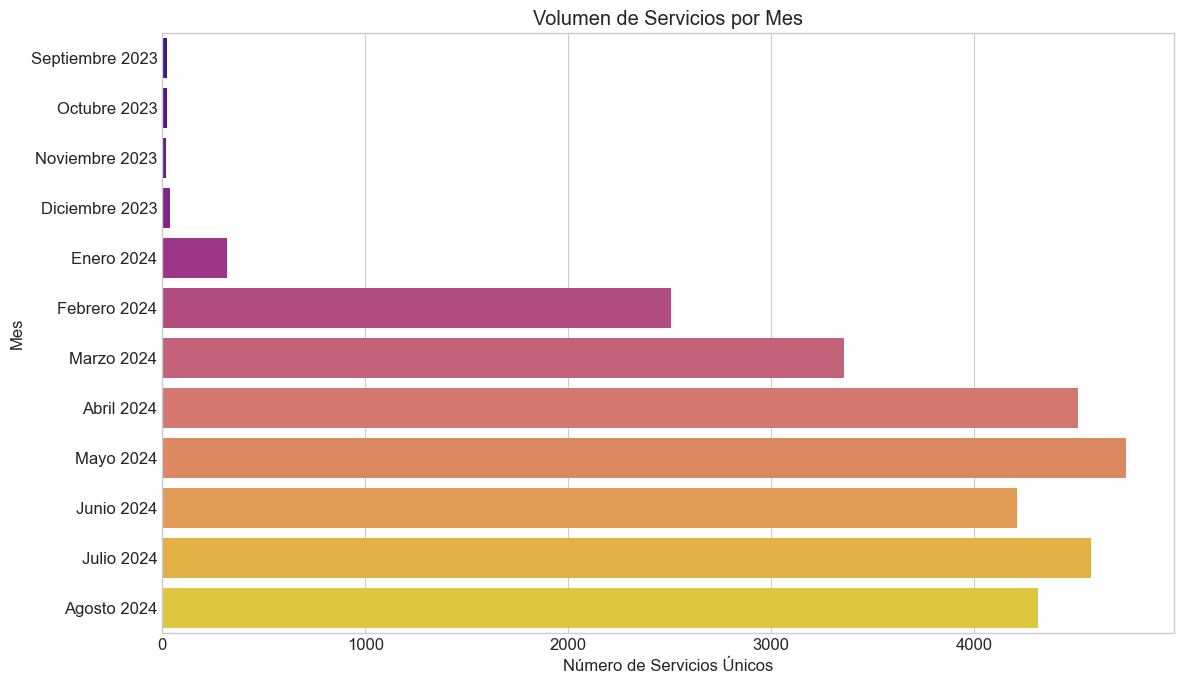

In [3]:
# -----------------------------------------------------------------------------
# --- Pregunta 1: ¿En qué meses del año se solicitan más servicios? ---
# -----------------------------------------------------------------------------
print("\n--- Análisis 1: Volumen de Servicios por Mes ---")

query_p1 = """
    SELECT
        df.Ano,
        df.Nombre_Mes,
        COUNT(DISTINCT f.Servicio_ID_Operacional) AS Total_Servicios
    FROM Fact_Cambio_Estado_Servicio f
    JOIN Dim_Fecha df ON f.Fecha_Key = df.Fecha_Key
    GROUP BY df.Ano, df.Nombre_Mes, df.Numero_Mes
    ORDER BY df.Ano, df.Numero_Mes;
"""
df_p1 = query_dw(query_p1, conn)
df_p1['Mes_Ano'] = df_p1['Nombre_Mes'] + ' ' + df_p1['Ano'].astype(str)

print("Datos:")
print(df_p1[['Mes_Ano', 'Total_Servicios']])

plt.figure()
sns.barplot(data=df_p1, x='Total_Servicios', y='Mes_Ano', orient='h', palette='plasma')
plt.title('Volumen de Servicios por Mes')
plt.xlabel('Número de Servicios Únicos')
plt.ylabel('Mes')
plt.tight_layout()
plt.show()


--- Análisis 2 y 3: Demanda por Día y Hora ---

Datos por Día de la Semana:
  Nombre_Dia_Semana  Total_Servicios
0             Lunes             4313
1            Martes             5415
2         Miércoles             4979
3            Jueves             5166
4           Viernes             5302
5            Sábado             2494
6           Domingo              841


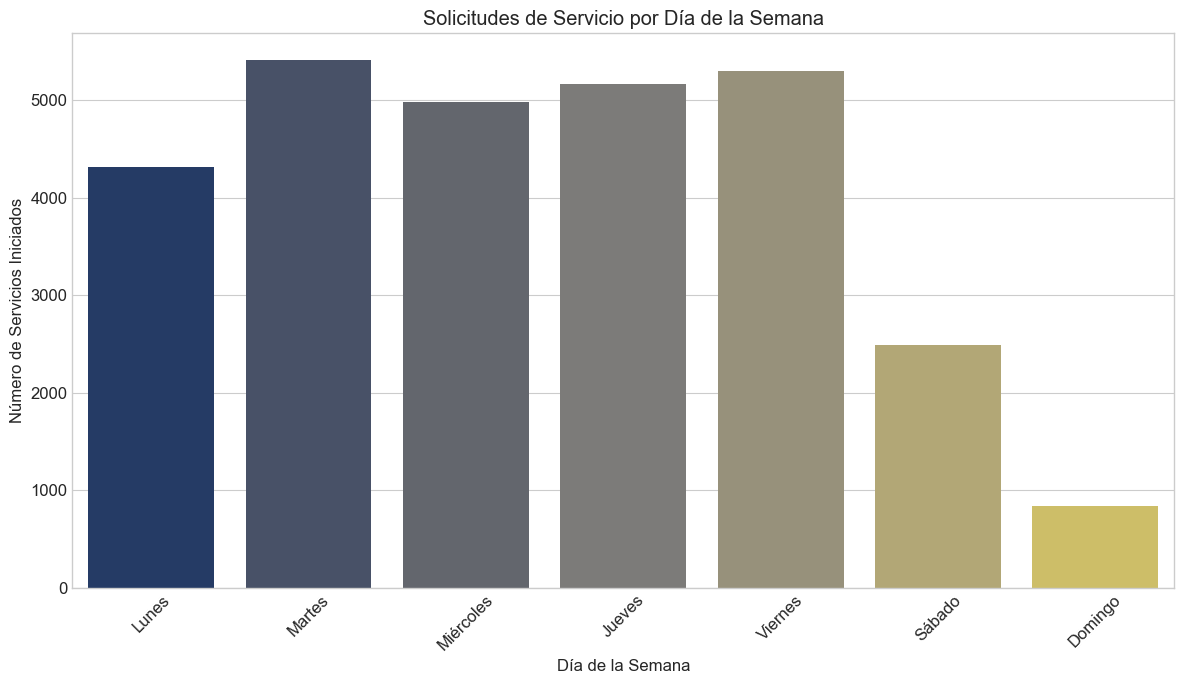


Datos por Hora del Día:
    Hora_Del_Dia  Total_Servicios
0              0                1
1              1                4
2              2                5
3              3                2
4              4                3
5              5                1
6              6                8
7              7               18
8              8               36
9              9               66
10            10               52
11            11               62
12            12               25
13            13               36
14            14               39
15            15               51
16            16               62
17            17               21
18            18                7
19            19                4
20            20                9
21            21                4
22            22                2
23            23                6


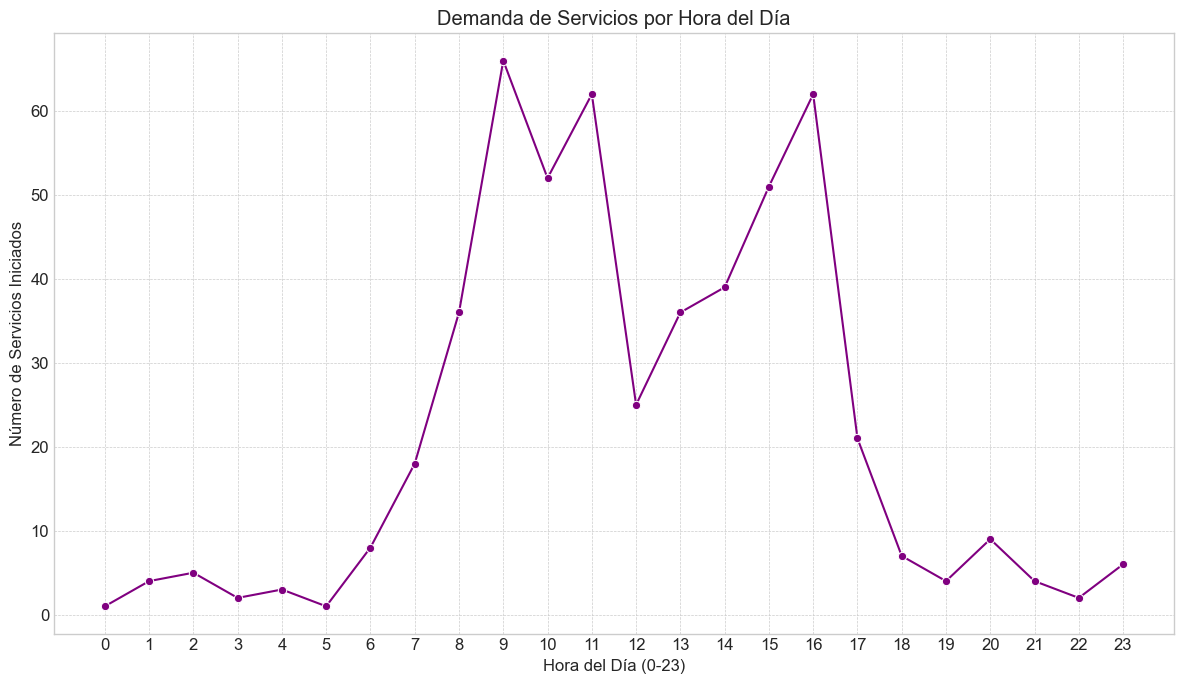

In [3]:
# -----------------------------------------------------------------------------
# --- Pregunta 2 y 3: ¿Qué días y horas tienen más solicitudes? ---
# -----------------------------------------------------------------------------
print("\n--- Análisis 2 y 3: Demanda por Día y Hora ---")

# Análisis por día
query_p2_dias = """
    SELECT
        df.Nombre_Dia_Semana,
        COUNT(DISTINCT f.Servicio_ID_Operacional) AS Total_Servicios
    FROM Fact_Cambio_Estado_Servicio f
    JOIN Dim_Fecha df ON f.Fecha_Key = df.Fecha_Key
    JOIN Dim_Estado_Servicio des ON f.Estado_Servicio_Key = des.Estado_Servicio_Key
    WHERE des.Nombre_Estado = 'Iniciado'
    GROUP BY df.Numero_Dia_Semana, df.Nombre_Dia_Semana
    ORDER BY df.Numero_Dia_Semana;
"""
df_p2_dias = query_dw(query_p2_dias, conn)

print("\nDatos por Día de la Semana:")
print(df_p2_dias)

plt.figure()
sns.barplot(data=df_p2_dias, x='Nombre_Dia_Semana', y='Total_Servicios', palette='cividis')
plt.title('Solicitudes de Servicio por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Número de Servicios Iniciados')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análisis por hora
query_p3_horas = """
    SELECT
        dh.Hora_Del_Dia,
        COUNT(DISTINCT f.Servicio_ID_Operacional) AS Total_Servicios
    FROM Fact_Cambio_Estado_Servicio f
    JOIN Dim_Hora dh ON f.Hora_Key = dh.Hora_Key
    JOIN Dim_Estado_Servicio des ON f.Estado_Servicio_Key = des.Estado_Servicio_Key
    WHERE des.Nombre_Estado = 'Iniciado'
    GROUP BY dh.Hora_Del_Dia
    ORDER BY dh.Hora_Del_Dia;
"""
df_p3_horas = query_dw(query_p3_horas, conn)

print("\nDatos por Hora del Día:")
print(df_p3_horas)

plt.figure()
sns.lineplot(data=df_p3_horas, x='Hora_Del_Dia', y='Total_Servicios', marker='o', color='purple')
plt.title('Demanda de Servicios por Hora del Día')
plt.xlabel('Hora del Día (0-23)')
plt.ylabel('Número de Servicios Iniciados')
plt.xticks(range(0, 24))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



--- Análisis 4: Servicios por Cliente y Mes (Top 10 Clientes) ---
Datos (Matriz Cliente vs Mes):
Mes_Ano                              Abril 2024  Agosto 2024  Diciembre 2023  \
Nombre_Cliente                                                                 
BANCO REGIONAL  DE SANGRE BLOD-LIFE        51.0         31.0             0.0   
CALI SULUD Y VIDA                         133.0        175.0             0.0   
CARROS DEL  PACIFICO (CHINA)             2766.0       2789.0             5.0   
CLINICA  DEPORTIVA DEL SUR                 41.0         39.0             0.0   
CLINICA CALI -JOVEN                       725.0        629.0            31.0   
CLINICA COFFE -HEALTH                     427.0        269.0             0.0   
CLINICA DEL SUR DE CALI                   265.0        133.0             0.0   
CLINICA NEFROLOGOS  DE CALI                14.0        100.0             0.0   
CRUZ AZUL-LIFE                              8.0         16.0             1.0   
UNIDAD DE TRAUMA DEL O

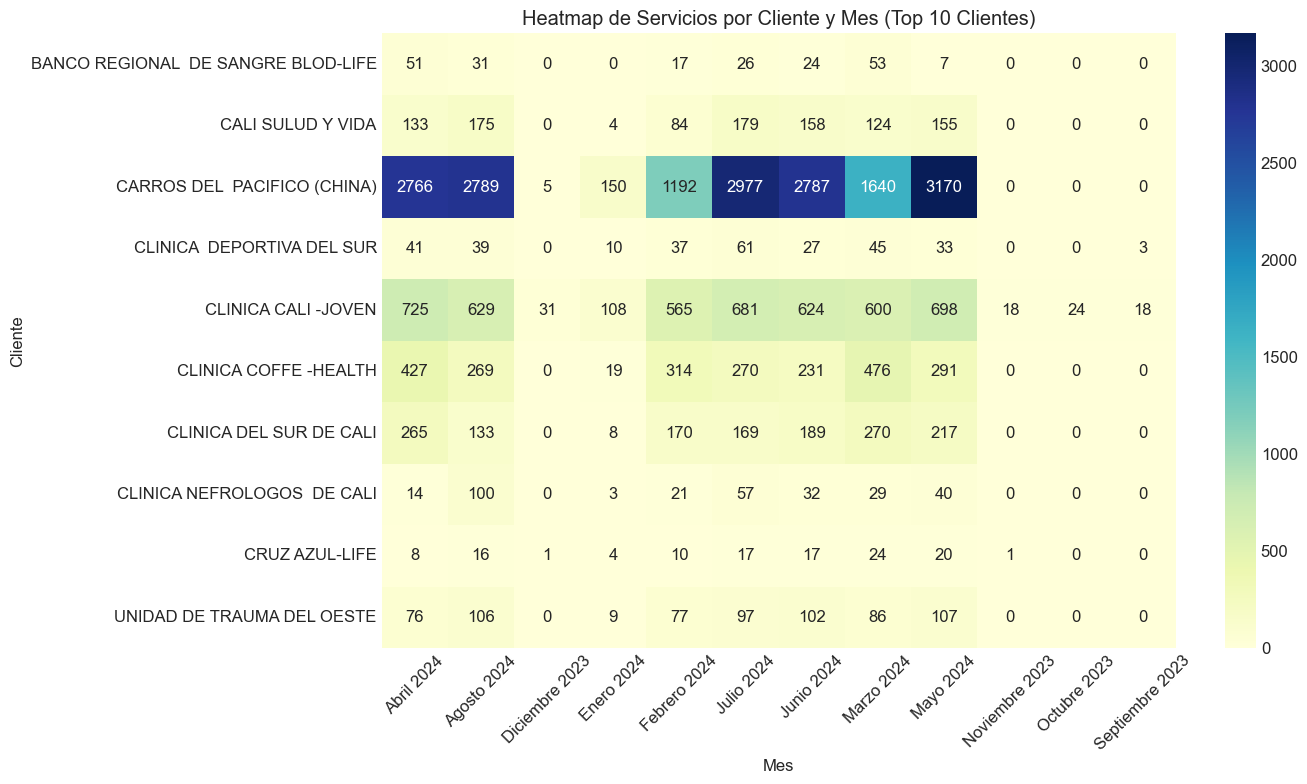

In [4]:
# -----------------------------------------------------------------------------
# --- Pregunta 4: ¿Número de servicios por cliente y mes? ---
# -----------------------------------------------------------------------------
print("\n--- Análisis 4: Servicios por Cliente y Mes (Top 10 Clientes) ---")
query_p4 = """
    WITH ServiciosPorClienteMes AS (
        SELECT
            dc.Nombre_Cliente,
            df.Ano,
            df.Nombre_Mes,
            df.Numero_Mes,
            COUNT(DISTINCT f.Servicio_ID_Operacional) AS Total_Servicios
        FROM Fact_Cambio_Estado_Servicio f
        JOIN Dim_Cliente dc ON f.Cliente_Key = dc.Cliente_Key
        JOIN Dim_Fecha df ON f.Fecha_Key = df.Fecha_Key
        GROUP BY dc.Nombre_Cliente, df.Ano, df.Nombre_Mes, df.Numero_Mes
    ),
    RankingClientes AS (
        SELECT 
            Nombre_Cliente, 
            SUM(Total_Servicios) as Suma_Total 
        FROM ServiciosPorClienteMes 
        GROUP BY Nombre_Cliente 
        ORDER BY Suma_Total DESC 
        LIMIT 10
    )
    SELECT 
        spcm.*
    FROM ServiciosPorClienteMes spcm
    JOIN RankingClientes rc ON spcm.Nombre_Cliente = rc.Nombre_Cliente
    ORDER BY spcm.Ano, spcm.Numero_Mes;
"""
df_p4 = query_dw(query_p4, conn)
df_p4['Mes_Ano'] = df_p4['Nombre_Mes'] + ' ' + df_p4['Ano'].astype(str)

pivot_df_p4 = df_p4.pivot_table(index='Nombre_Cliente', columns='Mes_Ano', values='Total_Servicios', fill_value=0)

print("Datos (Matriz Cliente vs Mes):")
print(pivot_df_p4)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df_p4, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Heatmap de Servicios por Cliente y Mes (Top 10 Clientes)')
plt.xlabel('Mes')
plt.ylabel('Cliente')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



--- Análisis 5: Mensajeros más Eficientes (Top 15) ---
Datos:
                     Nombre_Mensajero  Total_Servicios_Prestados
0  pepito_el_rapido pepito_el_furioso                      27703


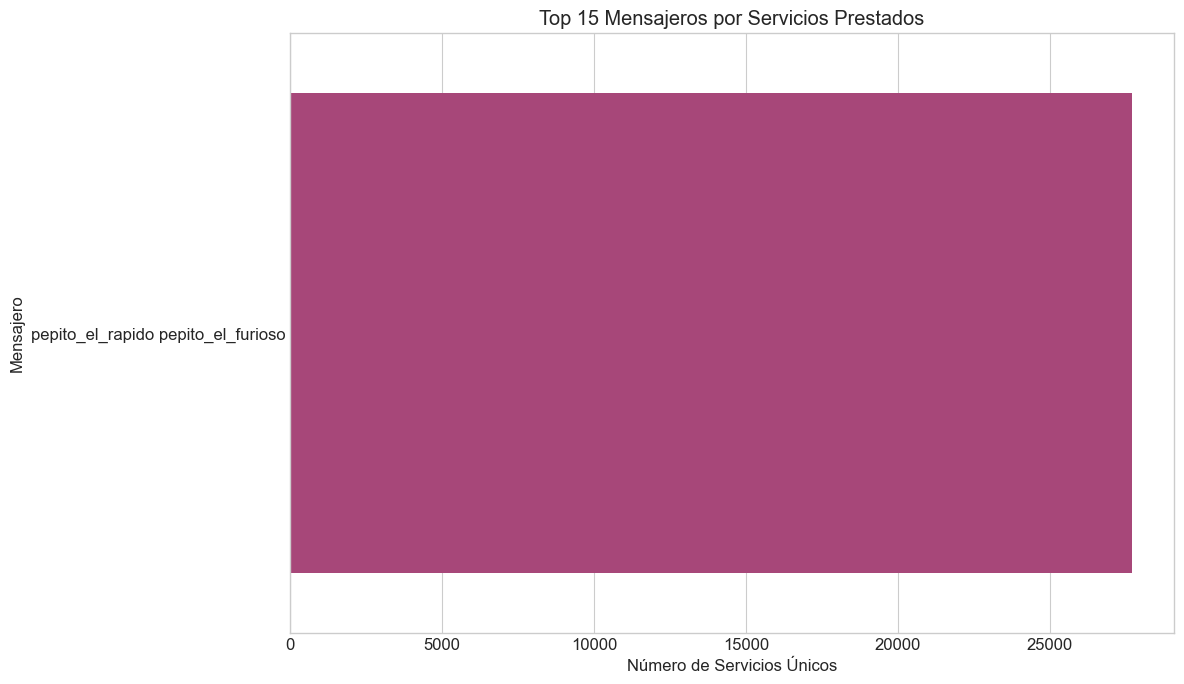

In [5]:
# -----------------------------------------------------------------------------
# --- Pregunta 5: ¿Mensajeros más eficientes (con más servicios)? ---
# -----------------------------------------------------------------------------
print("\n--- Análisis 5: Mensajeros más Eficientes (Top 15) ---")
query_p5 = """
    SELECT
        dm.Nombre_Mensajero,
        COUNT(DISTINCT f.Servicio_ID_Operacional) AS Total_Servicios_Prestados
    FROM Fact_Cambio_Estado_Servicio f
    JOIN Dim_Mensajero dm ON f.Mensajero_Key = dm.Mensajero_Key
    WHERE f.Mensajero_Key IS NOT NULL
    GROUP BY dm.Nombre_Mensajero
    ORDER BY Total_Servicios_Prestados DESC
    LIMIT 15;
"""
df_p5 = query_dw(query_p5, conn)

print("Datos:")
print(df_p5)

plt.figure()
sns.barplot(data=df_p5, y='Nombre_Mensajero', x='Total_Servicios_Prestados', orient='h', palette='magma')
plt.title('Top 15 Mensajeros por Servicios Prestados')
plt.ylabel('Mensajero')
plt.xlabel('Número de Servicios Únicos')
plt.tight_layout()
plt.show()



--- Análisis 6: Sedes con más Solicitudes (Top 20 General) ---
Datos:
                                         Sede_Cliente  Total_Servicios
0   PRINCIPAL NORTE / CHINA PACIFICO (CARROS DEL  ...             6853
1   BUSES Y CAMIONES - (CARROS DEL  PACIFICO (CHINA))             5459
2   PALMIRA BODEGA 20  /   (CARROS DEL  PACIFICO (...             1755
3                CLINICA CALI (CLINICA COFFE -HEALTH)             1373
4   MEGATALLER / CHINA PACIFICO (CARROS DEL  PACIF...             1210
5           CLINICA FABILUX (CLINICA DEL SUR DE CALI)             1061
6         PRINCIPAL / OCCIDENTE (CLINICA CALI -JOVEN)             1011
7                  CRISTO REY (CLINICA COFFE -HEALTH)              917
8                 VILLACOLOMBIA (CLINICA CALI -JOVEN)              876
9                     CAPITOLIO (CLINICA CALI -JOVEN)              755
10                 VASQUEZ COBO (CLINICA CALI -JOVEN)              686
11          TORRES DE MARACAIBO (CLINICA CALI -JOVEN)              666
12    

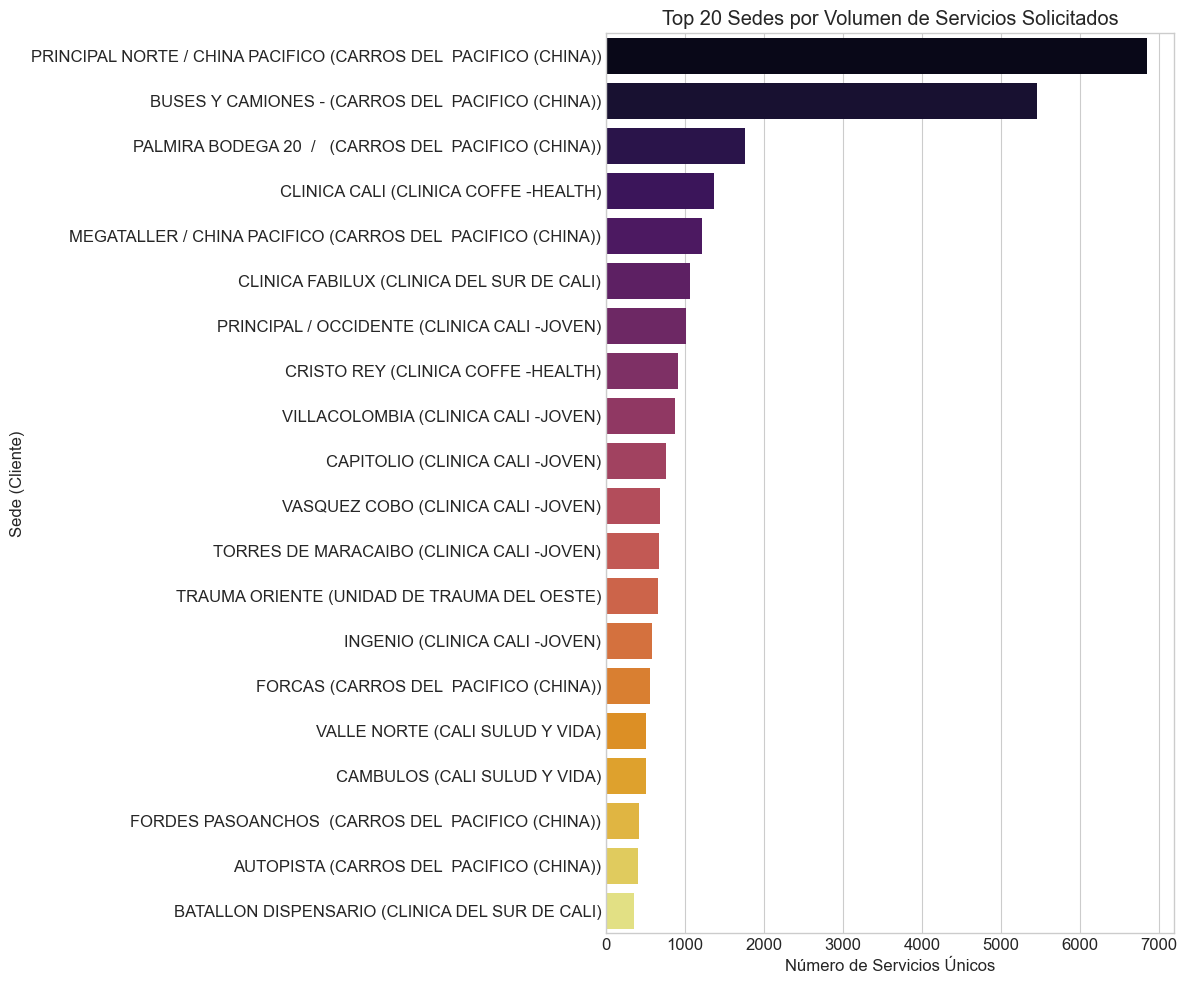

In [6]:
# -----------------------------------------------------------------------------
# --- Pregunta 6: ¿Sedes que más servicios solicitan por cliente? ---
# -----------------------------------------------------------------------------
print("\n--- Análisis 6: Sedes con más Solicitudes (Top 20 General) ---")
query_p6 = """
    SELECT
        dc.Nombre_Cliente,
        ds.Nombre_Sede,
        COUNT(DISTINCT f.Servicio_ID_Operacional) AS Total_Servicios
    FROM Fact_Cambio_Estado_Servicio f
    JOIN Dim_Sede ds ON f.Sede_Origen_Key = ds.Sede_Key
    JOIN Dim_Cliente dc ON ds.Cliente_Key = dc.Cliente_Key
    GROUP BY dc.Nombre_Cliente, ds.Nombre_Sede
    ORDER BY Total_Servicios DESC
    LIMIT 20;
"""
df_p6 = query_dw(query_p6, conn)
df_p6['Sede_Cliente'] = df_p6['Nombre_Sede'] + ' (' + df_p6['Nombre_Cliente'] + ')'

print("Datos:")
print(df_p6[['Sede_Cliente', 'Total_Servicios']])

plt.figure(figsize=(12, 10))
sns.barplot(data=df_p6, y='Sede_Cliente', x='Total_Servicios', orient='h', palette='inferno')
plt.title('Top 20 Sedes por Volumen de Servicios Solicitados')
plt.ylabel('Sede (Cliente)')
plt.xlabel('Número de Servicios Únicos')
plt.tight_layout()
plt.show()



--- Análisis 7 y 8: Tiempos de Entrega y Demoras por Fase ---

Datos de demoras por fase del servicio (Pregunta 8):
                                               Fase  Tiempo_Promedio_Horas
0        Entregado en destino -> Terminado completo               4.454409
1             Con novedad -> Recogido por mensajero               1.726312
2                Iniciado -> Con mensajero Asignado               1.601175
3             Con mensajero Asignado -> Con novedad               1.164695
4    Recogido por mensajero -> Entregado en destino               1.106576
5    Con mensajero Asignado -> Entregado en destino               0.950556
6      Recogido por mensajero -> Terminado completo               0.935833
7  Con mensajero Asignado -> Recogido por mensajero               0.895656


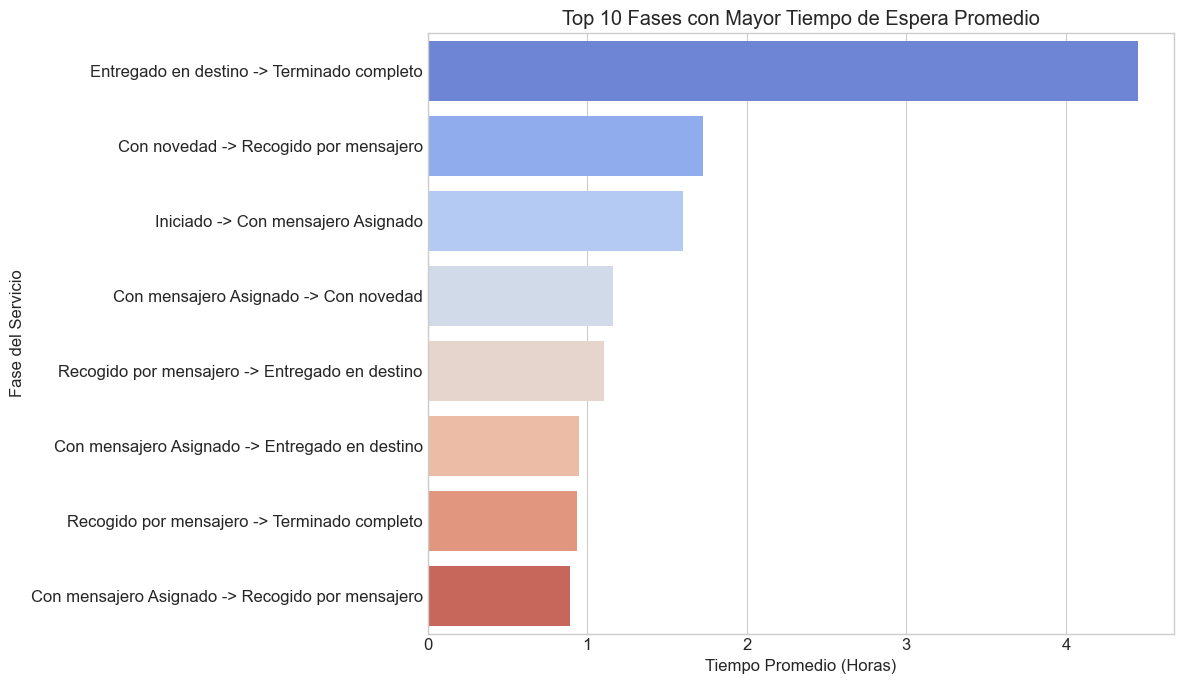


Respuesta Pregunta 7: El tiempo promedio de entrega total (de inicio a cierre) es: 9.18 horas.


In [19]:
# -----------------------------------------------------------------------------
# --- Pregunta 7 y 8: ¿Tiempo promedio de entrega y demoras por fase? ---
# -----------------------------------------------------------------------------
print("\n--- Análisis 7 y 8: Tiempos de Entrega y Demoras por Fase ---")

# Pregunta 8: Demoras por fase
query_p8_fases = """
    WITH TimestampsOrdenados AS (
        SELECT
            Servicio_ID_Operacional,
            des.Nombre_Estado,
            f.Timestamp_Estado,
            LAG(f.Timestamp_Estado, 1, 0) OVER (
                PARTITION BY f.Servicio_ID_Operacional 
                ORDER BY des.Orden_Estado, f.Timestamp_Estado
            ) AS Timestamp_Anterior,
            LAG(des.Nombre_Estado, 1, 'Solicitado') OVER (
                PARTITION BY f.Servicio_ID_Operacional 
                ORDER BY des.Orden_Estado, f.Timestamp_Estado
            ) AS Estado_Anterior
        FROM Fact_Cambio_Estado_Servicio f
        JOIN Dim_Estado_Servicio des ON f.Estado_Servicio_Key = des.Estado_Servicio_Key
    ),
    DuracionFases AS (
        SELECT
            Estado_Anterior,
            Nombre_Estado AS Estado_Actual,
            (julianday(Timestamp_Estado) - julianday(Timestamp_Anterior)) * 24 AS Duracion_Horas
        FROM TimestampsOrdenados
        WHERE Timestamp_Anterior != 0
    )
    SELECT
        Estado_Anterior || ' -> ' || Estado_Actual AS Fase,
        AVG(Duracion_Horas) AS Tiempo_Promedio_Horas
    FROM DuracionFases
    WHERE Duracion_Horas >= 0 
      AND Duracion_Horas < 500 -- Filtro para valores atípicos
      AND Estado_Anterior != Estado_Actual -- Ignorar transiciones al mismo estado
    GROUP BY Fase
    ORDER BY Tiempo_Promedio_Horas DESC;
"""
df_p8_fases = query_dw(query_p8_fases, conn)

print("\nDatos de demoras por fase del servicio (Pregunta 8):")
print(df_p8_fases)

plt.figure()
sns.barplot(data=df_p8_fases.head(10), y='Fase', x='Tiempo_Promedio_Horas', orient='h', palette='coolwarm')
plt.title('Top 10 Fases con Mayor Tiempo de Espera Promedio')
plt.ylabel('Fase del Servicio')
plt.xlabel('Tiempo Promedio (Horas)')
plt.tight_layout()
plt.show()


# Pregunta 7: Tiempo total promedio
query_p7_total = """
    WITH TiemposExtremos AS (
        SELECT
            Servicio_ID_Operacional,
            MIN(Timestamp_Estado) AS Inicio_Servicio,
            MAX(CASE WHEN des.Nombre_Estado = 'Terminado completo' THEN f.Timestamp_Estado END) AS Fin_Servicio
        FROM Fact_Cambio_Estado_Servicio f
        JOIN Dim_Estado_Servicio des ON f.Estado_Servicio_Key = des.Estado_Servicio_Key
        GROUP BY Servicio_ID_Operacional
        HAVING Fin_Servicio IS NOT NULL
    ),
    DuracionTotal AS (
       SELECT (julianday(Fin_Servicio) - julianday(Inicio_Servicio)) * 24 AS Tiempo_Total_Horas FROM TiemposExtremos
    )
    SELECT AVG(Tiempo_Total_Horas) AS Tiempo_Promedio_Total_Horas
    FROM DuracionTotal
    WHERE Tiempo_Total_Horas >= 0 AND Tiempo_Total_Horas < 1000; -- Filtro atípicos
"""
df_p7_total = query_dw(query_p7_total, conn)
tiempo_promedio = df_p7_total['Tiempo_Promedio_Total_Horas'].iloc[0]

if pd.notna(tiempo_promedio):
    print(f"\nRespuesta Pregunta 7: El tiempo promedio de entrega total (de inicio a cierre) es: {tiempo_promedio:.2f} horas.")
else:
    print("\nRespuesta Pregunta 7: No hay datos suficientes para calcular el tiempo promedio de entrega.")



--- Análisis 9: Novedades más Frecuentes ---
Datos:
      Descripcion_Novedad  Total_Ocurrencias
0  Novedades del servicio              14725
1      No puedo continuar               6318


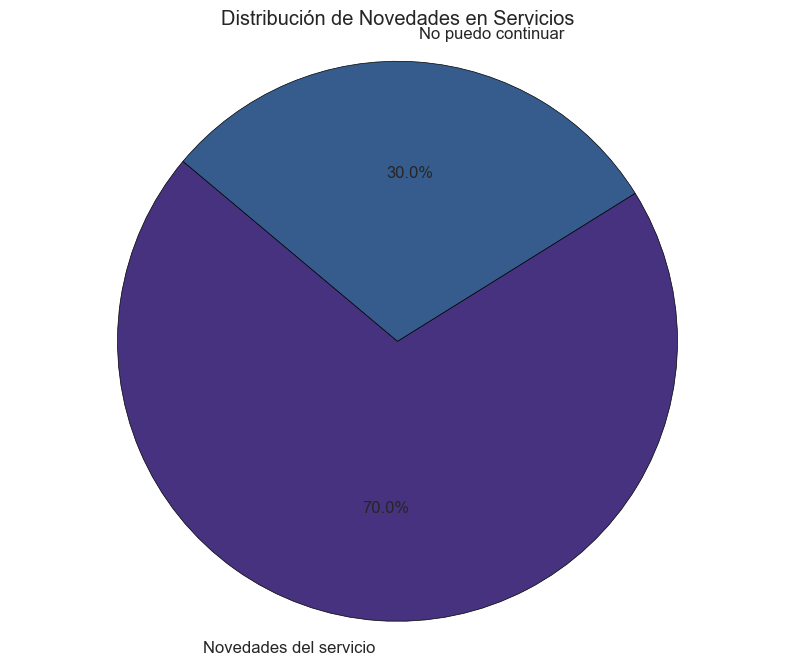

In [9]:
# -----------------------------------------------------------------------------
# --- Pregunta 9: ¿Novedades que más se presentan? ---
# -----------------------------------------------------------------------------
print("\n--- Análisis 9: Novedades más Frecuentes ---")
query_p9 = """
    SELECT
        dn.Descripcion_Novedad,
        COUNT(*) AS Total_Ocurrencias
    FROM Fact_Cambio_Estado_Servicio f
    JOIN Dim_Novedad dn ON f.Novedad_Key = dn.Novedad_Key
    WHERE dn.Descripcion_Novedad != 'Sin Novedad'
    GROUP BY dn.Descripcion_Novedad
    ORDER BY Total_Ocurrencias DESC;
"""
df_p9 = query_dw(query_p9, conn)

print("Datos:")
print(df_p9)

if not df_p9.empty:
    plt.figure(figsize=(10, 8))
    plt.pie(df_p9['Total_Ocurrencias'], labels=df_p9['Descripcion_Novedad'], autopct='%1.1f%%', startangle=140,
            wedgeprops={"edgecolor":"k",'linewidth': 0.5, 'antialiased': True})
    plt.title('Distribución de Novedades en Servicios')
    plt.axis('equal')  # Asegura que el pie chart sea un círculo.
    plt.show()
else:
    print("No se encontraron novedades para graficar.")


In [ ]:
# --- Cierre de Conexión ---
conn.close()
print("\n--- ANÁLISIS COMPLETADO ---")
